In [23]:
import pandas as pd
import numpy as np
import random
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

# Optuna
import optuna

warnings.filterwarnings("ignore")

In [ ]:
# ===== 1. ĐỌC DỮ LIỆU =====
df = pd.read_excel("carprice_clean.xlsx", sheet_name=0, engine="openpyxl")
df.drop(columns=['mileage', 'torque', 'mileage_numeric', 'mileage_unit', 'torque_unit_extracted'], inplace=True)


In [25]:

# ===== 2. Khai báo biến =====
target_variable = 'selling_price'
numerical_cols = ['year', 'km_driven', 'engine', 'max_power', 'seats',
                  'mileage_kmpl_equivalent', 'torque_Nm']
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']


In [26]:
# ===== 3. Train-test split =====
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [27]:
# ===== 4. Transformer: Target Encoding smooth (dùng y thay vì X[target]) =====
class TargetEncoderSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, cols, alpha=5):
        self.cols = cols
        self.alpha = alpha
        self.smoothing_dict_ = {}

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        for col in self.cols:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            agg = df_temp.groupby(col)['target'].agg(['mean','count'])
            smooth = (agg['mean'] * agg['count'] + self.global_mean_ * self.alpha) / (agg['count'] + self.alpha)
            self.smoothing_dict_[col] = smooth.to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            mapping = self.smoothing_dict_[col]
            X_copy[col + '_te'] = X_copy[col].map(mapping).fillna(self.global_mean_)
            X_copy.drop(columns=[col], inplace=True)
        return X_copy


In [28]:
# ===== 5. Tạo pipeline chung không scale cho Random Forest =====
encoded_features = ['fuel', 'seller_type', 'transmission']  # OneHot
te_features = ['name', 'owner']                             # TargetEncode
all_features = numerical_cols + te_features + encoded_features

def build_pipeline(feature_subset, params=None):
    # Steps: impute numeric (no scaling), one-hot categorical, target encode name/owner -> model
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
        ]), [f for f in feature_subset if f in numerical_cols]),
        ('te', TargetEncoderSmooth(cols=[f for f in feature_subset if f in te_features]), [f for f in feature_subset if f in te_features]),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), [f for f in feature_subset if f in encoded_features])
    ], remainder='drop')

    model = RandomForestRegressor(**params) if params else RandomForestRegressor(random_state=42, n_jobs=-1)

    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    return pipeline


In [29]:
# ===== 6. Backward feature selection =====
X = train_df[all_features]
y = train_df[target_variable]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
history = []

# full model
tree_default = {'random_state':42, 'n_jobs':-1}
full_pipe = build_pipeline(all_features, params=tree_default)
full_rmse = -cross_val_score(full_pipe, X, y, scoring='neg_root_mean_squared_error', cv=kf).mean()
history.append((deepcopy(all_features), full_rmse))

features = deepcopy(all_features)
while len(features) > 1:
    scores = {}
    for feat in features:
        subset = [f for f in features if f != feat]
        rmse = -cross_val_score(build_pipeline(subset, params=tree_default),
                                 X[subset], y, scoring='neg_root_mean_squared_error', cv=kf).mean()
        scores[feat] = rmse
    worst = min(scores, key=scores.get)
    features.remove(worst)
    history.append((features.copy(), scores[worst]))

# Lấy best_feats
best_feats, best_rmse = min(history, key=lambda x: x[1])
print(f"Selected: {best_feats}, RMSE: {best_rmse:.2f}")


Selected: ['year', 'max_power', 'mileage_kmpl_equivalent', 'torque_Nm', 'name'], RMSE: 156968.91


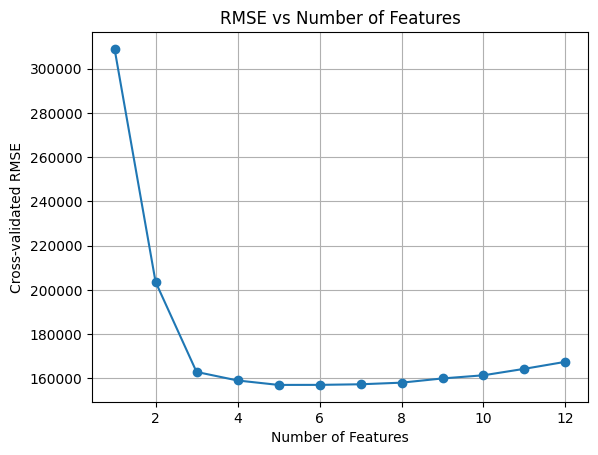

In [30]:
# Plot RMSE theo số lượng feature
import matplotlib.pyplot as plt
plt.plot([len(f) for f, _ in history], [rmse for _, rmse in history], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs Number of Features")
plt.grid(True)
plt.show()

In [31]:
# ===== 7. Optuna tuning =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

X_train_sub = train_df[best_feats]
y_train_sub = train_df[target_variable]

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth':    trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
        'min_samples_leaf':  trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt','log2',0.3,0.5,0.7]),
        'bootstrap':    trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED,
        'n_jobs': 1
    }
    pipe = build_pipeline(best_feats, params=params)
    rmse = -cross_val_score(pipe, X_train_sub, y_train_sub,
                             scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
    return rmse

study.optimize(objective, n_trials=100, show_progress_bar=True)
print("Best RMSE:", round(study.best_value,2))
print("Best params:", study.best_params)

[I 2025-06-18 11:14:18,469] A new study created in memory with name: no-name-7a4d4f4d-c8a0-48fb-a374-f393fd08bd8f
Best trial: 0. Best value: 202504:   1%|          | 1/100 [00:10<16:35, 10.06s/it]

[I 2025-06-18 11:14:28,527] Trial 0 finished with value: 202503.52451171138 and parameters: {'n_estimators': 562, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.5, 'bootstrap': True}. Best is trial 0 with value: 202503.52451171138.


Best trial: 1. Best value: 192261:   2%|▏         | 2/100 [00:24<20:58, 12.84s/it]

[I 2025-06-18 11:14:43,318] Trial 1 finished with value: 192261.02999747213 and parameters: {'n_estimators': 979, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 1 with value: 192261.02999747213.


Best trial: 1. Best value: 192261:   3%|▎         | 3/100 [00:35<19:05, 11.81s/it]

[I 2025-06-18 11:14:53,892] Trial 2 finished with value: 202646.25159380812 and parameters: {'n_estimators': 504, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.7, 'bootstrap': True}. Best is trial 1 with value: 192261.02999747213.


Best trial: 3. Best value: 176897:   4%|▍         | 4/100 [00:56<24:38, 15.40s/it]

[I 2025-06-18 11:15:14,796] Trial 3 finished with value: 176897.4759093068 and parameters: {'n_estimators': 965, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:   5%|▌         | 5/100 [01:02<19:22, 12.23s/it]

[I 2025-06-18 11:15:21,420] Trial 4 finished with value: 213957.1515173743 and parameters: {'n_estimators': 481, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.3, 'bootstrap': True}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:   6%|▌         | 6/100 [01:15<19:06, 12.19s/it]

[I 2025-06-18 11:15:33,535] Trial 5 finished with value: 190401.38347649967 and parameters: {'n_estimators': 946, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:   7%|▋         | 7/100 [01:22<16:35, 10.70s/it]

[I 2025-06-18 11:15:41,162] Trial 6 finished with value: 197395.08468281548 and parameters: {'n_estimators': 398, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.5, 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:   8%|▊         | 8/100 [01:28<14:06,  9.20s/it]

[I 2025-06-18 11:15:47,154] Trial 7 finished with value: 212648.7517187653 and parameters: {'n_estimators': 351, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:   9%|▉         | 9/100 [01:40<15:18, 10.10s/it]

[I 2025-06-18 11:15:59,215] Trial 8 finished with value: 225272.17938338168 and parameters: {'n_estimators': 921, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.3, 'bootstrap': True}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:  10%|█         | 10/100 [01:45<12:31,  8.35s/it]

[I 2025-06-18 11:16:03,641] Trial 9 finished with value: 220219.89880279437 and parameters: {'n_estimators': 375, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:  11%|█         | 11/100 [02:01<15:51, 10.69s/it]

[I 2025-06-18 11:16:19,654] Trial 10 finished with value: 181211.59134541202 and parameters: {'n_estimators': 760, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:  12%|█▏        | 12/100 [02:16<17:46, 12.12s/it]

[I 2025-06-18 11:16:35,039] Trial 11 finished with value: 181649.92212227962 and parameters: {'n_estimators': 761, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:  13%|█▎        | 13/100 [02:32<19:23, 13.37s/it]

[I 2025-06-18 11:16:51,287] Trial 12 finished with value: 181326.25981951266 and parameters: {'n_estimators': 798, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 3. Best value: 176897:  14%|█▍        | 14/100 [02:48<20:08, 14.05s/it]

[I 2025-06-18 11:17:06,923] Trial 13 finished with value: 177170.28877634733 and parameters: {'n_estimators': 721, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 176897.4759093068.


Best trial: 14. Best value: 167861:  15%|█▌        | 15/100 [03:03<20:18, 14.33s/it]

[I 2025-06-18 11:17:21,895] Trial 14 finished with value: 167860.50299288452 and parameters: {'n_estimators': 678, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 14 with value: 167860.50299288452.


Best trial: 15. Best value: 160727:  16%|█▌        | 16/100 [03:29<24:49, 17.74s/it]

[I 2025-06-18 11:17:47,538] Trial 15 finished with value: 160727.3829363989 and parameters: {'n_estimators': 860, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 15 with value: 160727.3829363989.


Best trial: 15. Best value: 160727:  17%|█▋        | 17/100 [03:48<25:16, 18.28s/it]

[I 2025-06-18 11:18:07,068] Trial 16 finished with value: 160926.33417027042 and parameters: {'n_estimators': 656, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 15 with value: 160727.3829363989.


Best trial: 17. Best value: 159784:  18%|█▊        | 18/100 [04:13<27:53, 20.41s/it]

[I 2025-06-18 11:18:32,433] Trial 17 finished with value: 159784.01338145236 and parameters: {'n_estimators': 841, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  19%|█▉        | 19/100 [04:31<26:15, 19.45s/it]

[I 2025-06-18 11:18:49,647] Trial 18 finished with value: 171556.90860535367 and parameters: {'n_estimators': 850, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  20%|██        | 20/100 [04:55<27:52, 20.91s/it]

[I 2025-06-18 11:19:13,970] Trial 19 finished with value: 165816.1978905889 and parameters: {'n_estimators': 860, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  21%|██        | 21/100 [05:17<27:47, 21.11s/it]

[I 2025-06-18 11:19:35,555] Trial 20 finished with value: 161399.2749715361 and parameters: {'n_estimators': 887, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  22%|██▏       | 22/100 [05:36<26:47, 20.61s/it]

[I 2025-06-18 11:19:54,976] Trial 21 finished with value: 160952.04574728507 and parameters: {'n_estimators': 652, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  23%|██▎       | 23/100 [05:53<25:03, 19.53s/it]

[I 2025-06-18 11:20:11,993] Trial 22 finished with value: 166042.93385095434 and parameters: {'n_estimators': 589, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  24%|██▍       | 24/100 [06:17<26:23, 20.84s/it]

[I 2025-06-18 11:20:35,894] Trial 23 finished with value: 160047.70971067395 and parameters: {'n_estimators': 814, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  25%|██▌       | 25/100 [06:35<25:08, 20.12s/it]

[I 2025-06-18 11:20:54,318] Trial 24 finished with value: 170582.91581111972 and parameters: {'n_estimators': 815, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 17. Best value: 159784:  26%|██▌       | 26/100 [07:00<26:22, 21.38s/it]

[I 2025-06-18 11:21:18,647] Trial 25 finished with value: 169037.57862228225 and parameters: {'n_estimators': 899, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 17 with value: 159784.01338145236.


Best trial: 26. Best value: 158887:  27%|██▋       | 27/100 [07:25<27:21, 22.49s/it]

[I 2025-06-18 11:21:43,720] Trial 26 finished with value: 158886.9745682138 and parameters: {'n_estimators': 814, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  28%|██▊       | 28/100 [07:45<26:10, 21.81s/it]

[I 2025-06-18 11:22:03,956] Trial 27 finished with value: 175554.50515763642 and parameters: {'n_estimators': 727, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.7, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  29%|██▉       | 29/100 [08:00<23:15, 19.65s/it]

[I 2025-06-18 11:22:18,566] Trial 28 finished with value: 171995.88143423025 and parameters: {'n_estimators': 810, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  30%|███       | 30/100 [08:15<21:26, 18.38s/it]

[I 2025-06-18 11:22:33,987] Trial 29 finished with value: 179760.37626708217 and parameters: {'n_estimators': 579, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.7, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  31%|███       | 31/100 [08:37<22:18, 19.40s/it]

[I 2025-06-18 11:22:55,769] Trial 30 finished with value: 167154.4633297205 and parameters: {'n_estimators': 1000, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  32%|███▏      | 32/100 [09:02<23:58, 21.16s/it]

[I 2025-06-18 11:23:21,018] Trial 31 finished with value: 160093.9296153198 and parameters: {'n_estimators': 845, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 26. Best value: 158887:  33%|███▎      | 33/100 [09:24<24:01, 21.51s/it]

[I 2025-06-18 11:23:43,364] Trial 32 finished with value: 165193.34966682157 and parameters: {'n_estimators': 771, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 26 with value: 158886.9745682138.


Best trial: 33. Best value: 158091:  34%|███▍      | 34/100 [09:46<23:45, 21.60s/it]

[I 2025-06-18 11:24:05,151] Trial 33 finished with value: 158091.00721268496 and parameters: {'n_estimators': 708, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  35%|███▌      | 35/100 [10:03<21:56, 20.25s/it]

[I 2025-06-18 11:24:22,274] Trial 34 finished with value: 173438.19483911697 and parameters: {'n_estimators': 699, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': True}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  36%|███▌      | 36/100 [10:12<18:03, 16.92s/it]

[I 2025-06-18 11:24:31,423] Trial 35 finished with value: 183513.0815973464 and parameters: {'n_estimators': 614, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  37%|███▋      | 37/100 [10:32<18:26, 17.56s/it]

[I 2025-06-18 11:24:50,474] Trial 36 finished with value: 167228.57311472358 and parameters: {'n_estimators': 742, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': True}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  38%|███▊      | 38/100 [10:44<16:41, 16.16s/it]

[I 2025-06-18 11:25:03,366] Trial 37 finished with value: 169468.3274901532 and parameters: {'n_estimators': 485, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  39%|███▉      | 39/100 [11:04<17:20, 17.05s/it]

[I 2025-06-18 11:25:22,497] Trial 38 finished with value: 187098.44790600616 and parameters: {'n_estimators': 943, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.5, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  40%|████      | 40/100 [11:15<15:24, 15.41s/it]

[I 2025-06-18 11:25:34,074] Trial 39 finished with value: 183759.61937308777 and parameters: {'n_estimators': 784, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': True}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  41%|████      | 41/100 [11:32<15:26, 15.71s/it]

[I 2025-06-18 11:25:50,488] Trial 40 finished with value: 163161.0267674484 and parameters: {'n_estimators': 536, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  42%|████▏     | 42/100 [11:57<17:54, 18.53s/it]

[I 2025-06-18 11:26:15,586] Trial 41 finished with value: 160012.9923015717 and parameters: {'n_estimators': 827, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  43%|████▎     | 43/100 [12:21<19:18, 20.33s/it]

[I 2025-06-18 11:26:40,125] Trial 42 finished with value: 160107.3254245207 and parameters: {'n_estimators': 823, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  44%|████▍     | 44/100 [12:45<20:04, 21.51s/it]

[I 2025-06-18 11:27:04,402] Trial 43 finished with value: 164741.5483393169 and parameters: {'n_estimators': 892, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  45%|████▌     | 45/100 [13:08<19:54, 21.71s/it]

[I 2025-06-18 11:27:26,578] Trial 44 finished with value: 163709.65689817062 and parameters: {'n_estimators': 926, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  46%|████▌     | 46/100 [13:26<18:32, 20.60s/it]

[I 2025-06-18 11:27:44,584] Trial 45 finished with value: 183532.87415865908 and parameters: {'n_estimators': 693, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  47%|████▋     | 47/100 [13:38<16:04, 18.20s/it]

[I 2025-06-18 11:27:57,197] Trial 46 finished with value: 216294.25090919877 and parameters: {'n_estimators': 747, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 0.5, 'bootstrap': True}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  48%|████▊     | 48/100 [13:45<12:41, 14.64s/it]

[I 2025-06-18 11:28:03,534] Trial 47 finished with value: 190266.8164954627 and parameters: {'n_estimators': 434, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  49%|████▉     | 49/100 [14:07<14:31, 17.09s/it]

[I 2025-06-18 11:28:26,316] Trial 48 finished with value: 168784.12566627716 and parameters: {'n_estimators': 831, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  50%|█████     | 50/100 [14:30<15:33, 18.68s/it]

[I 2025-06-18 11:28:48,706] Trial 49 finished with value: 165944.59194565116 and parameters: {'n_estimators': 793, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  51%|█████     | 51/100 [14:53<16:21, 20.03s/it]

[I 2025-06-18 11:29:11,884] Trial 50 finished with value: 168411.10227601556 and parameters: {'n_estimators': 965, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': True}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  52%|█████▏    | 52/100 [15:19<17:25, 21.79s/it]

[I 2025-06-18 11:29:37,785] Trial 51 finished with value: 160074.83475916708 and parameters: {'n_estimators': 850, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  53%|█████▎    | 53/100 [15:45<18:08, 23.17s/it]

[I 2025-06-18 11:30:04,173] Trial 52 finished with value: 159710.5405394653 and parameters: {'n_estimators': 880, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  54%|█████▍    | 54/100 [16:13<18:55, 24.68s/it]

[I 2025-06-18 11:30:32,368] Trial 53 finished with value: 159359.63571500132 and parameters: {'n_estimators': 907, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  55%|█████▌    | 55/100 [16:40<18:59, 25.31s/it]

[I 2025-06-18 11:30:59,162] Trial 54 finished with value: 163337.53703104 and parameters: {'n_estimators': 891, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  56%|█████▌    | 56/100 [17:11<19:45, 26.95s/it]

[I 2025-06-18 11:31:29,945] Trial 55 finished with value: 159409.86168212703 and parameters: {'n_estimators': 928, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  57%|█████▋    | 57/100 [17:20<15:32, 21.69s/it]

[I 2025-06-18 11:31:39,339] Trial 56 finished with value: 168966.87896127548 and parameters: {'n_estimators': 301, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  58%|█████▊    | 58/100 [17:52<17:17, 24.69s/it]

[I 2025-06-18 11:32:11,049] Trial 57 finished with value: 158878.81010601358 and parameters: {'n_estimators': 923, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  59%|█████▉    | 59/100 [18:16<16:43, 24.47s/it]

[I 2025-06-18 11:32:34,998] Trial 58 finished with value: 162658.2853742331 and parameters: {'n_estimators': 923, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  60%|██████    | 60/100 [18:48<17:47, 26.68s/it]

[I 2025-06-18 11:33:06,835] Trial 59 finished with value: 163455.66558664848 and parameters: {'n_estimators': 970, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  61%|██████    | 61/100 [19:18<18:02, 27.77s/it]

[I 2025-06-18 11:33:37,144] Trial 60 finished with value: 159143.21240430337 and parameters: {'n_estimators': 874, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  62%|██████▏   | 62/100 [19:50<18:25, 29.09s/it]

[I 2025-06-18 11:34:09,319] Trial 61 finished with value: 159481.12914040542 and parameters: {'n_estimators': 875, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  63%|██████▎   | 63/100 [20:24<18:48, 30.51s/it]

[I 2025-06-18 11:34:43,149] Trial 62 finished with value: 159539.12308122803 and parameters: {'n_estimators': 944, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  64%|██████▍   | 64/100 [20:57<18:45, 31.25s/it]

[I 2025-06-18 11:35:16,119] Trial 63 finished with value: 158938.5621550469 and parameters: {'n_estimators': 910, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 33. Best value: 158091:  65%|██████▌   | 65/100 [21:30<18:25, 31.60s/it]

[I 2025-06-18 11:35:48,536] Trial 64 finished with value: 163814.28527254544 and parameters: {'n_estimators': 915, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 33 with value: 158091.00721268496.


Best trial: 65. Best value: 157889:  66%|██████▌   | 66/100 [22:08<19:04, 33.65s/it]

[I 2025-06-18 11:36:26,980] Trial 65 finished with value: 157888.97636088385 and parameters: {'n_estimators': 978, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 65 with value: 157888.97636088385.


Best trial: 65. Best value: 157889:  67%|██████▋   | 67/100 [22:37<17:47, 32.36s/it]

[I 2025-06-18 11:36:56,325] Trial 66 finished with value: 160424.30268790256 and parameters: {'n_estimators': 998, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 65 with value: 157888.97636088385.


Best trial: 65. Best value: 157889:  68%|██████▊   | 68/100 [23:06<16:39, 31.25s/it]

[I 2025-06-18 11:37:24,972] Trial 67 finished with value: 173405.19608154087 and parameters: {'n_estimators': 981, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 65 with value: 157888.97636088385.


Best trial: 65. Best value: 157889:  69%|██████▉   | 69/100 [23:43<16:59, 32.88s/it]

[I 2025-06-18 11:38:01,669] Trial 68 finished with value: 163266.23520322586 and parameters: {'n_estimators': 907, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 65 with value: 157888.97636088385.


Best trial: 65. Best value: 157889:  70%|███████   | 70/100 [24:18<16:52, 33.75s/it]

[I 2025-06-18 11:38:37,459] Trial 69 finished with value: 158690.69533285563 and parameters: {'n_estimators': 958, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 65 with value: 157888.97636088385.


Best trial: 65. Best value: 157889:  71%|███████   | 71/100 [24:35<13:48, 28.57s/it]

[I 2025-06-18 11:38:53,919] Trial 70 finished with value: 191756.47223119205 and parameters: {'n_estimators': 952, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 65 with value: 157888.97636088385.


Best trial: 71. Best value: 157586:  72%|███████▏  | 72/100 [25:07<13:52, 29.72s/it]

[I 2025-06-18 11:39:26,318] Trial 71 finished with value: 157585.82991919148 and parameters: {'n_estimators': 874, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  73%|███████▎  | 73/100 [25:32<12:38, 28.07s/it]

[I 2025-06-18 11:39:50,562] Trial 72 finished with value: 185495.47372152907 and parameters: {'n_estimators': 868, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  74%|███████▍  | 74/100 [26:07<13:07, 30.28s/it]

[I 2025-06-18 11:40:25,997] Trial 73 finished with value: 158601.9411816312 and parameters: {'n_estimators': 982, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  75%|███████▌  | 75/100 [26:41<13:03, 31.34s/it]

[I 2025-06-18 11:40:59,817] Trial 74 finished with value: 158592.9726563361 and parameters: {'n_estimators': 973, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  76%|███████▌  | 76/100 [27:16<12:58, 32.43s/it]

[I 2025-06-18 11:41:34,769] Trial 75 finished with value: 162943.4270492868 and parameters: {'n_estimators': 984, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  77%|███████▋  | 77/100 [27:38<11:13, 29.30s/it]

[I 2025-06-18 11:41:56,768] Trial 76 finished with value: 173128.7808260541 and parameters: {'n_estimators': 954, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  78%|███████▊  | 78/100 [28:08<10:50, 29.57s/it]

[I 2025-06-18 11:42:26,977] Trial 77 finished with value: 161142.44698498648 and parameters: {'n_estimators': 977, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  79%|███████▉  | 79/100 [28:44<10:59, 31.41s/it]

[I 2025-06-18 11:43:02,678] Trial 78 finished with value: 183541.58176287365 and parameters: {'n_estimators': 947, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  80%|████████  | 80/100 [29:16<10:32, 31.63s/it]

[I 2025-06-18 11:43:34,836] Trial 79 finished with value: 162821.73194645892 and parameters: {'n_estimators': 625, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  81%|████████  | 81/100 [29:49<10:10, 32.15s/it]

[I 2025-06-18 11:44:08,193] Trial 80 finished with value: 163431.51676752698 and parameters: {'n_estimators': 961, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  82%|████████▏ | 82/100 [30:30<10:23, 34.61s/it]

[I 2025-06-18 11:44:48,549] Trial 81 finished with value: 158902.92722910573 and parameters: {'n_estimators': 937, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  83%|████████▎ | 83/100 [31:08<10:09, 35.88s/it]

[I 2025-06-18 11:45:27,387] Trial 82 finished with value: 158706.31433415416 and parameters: {'n_estimators': 993, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 71. Best value: 157586:  84%|████████▍ | 84/100 [31:45<09:39, 36.24s/it]

[I 2025-06-18 11:46:04,457] Trial 83 finished with value: 158679.53342573327 and parameters: {'n_estimators': 997, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 71 with value: 157585.82991919148.


Best trial: 84. Best value: 157208:  85%|████████▌ | 85/100 [32:19<08:50, 35.37s/it]

[I 2025-06-18 11:46:37,806] Trial 84 finished with value: 157208.131310914 and parameters: {'n_estimators': 999, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 84 with value: 157208.131310914.


Best trial: 85. Best value: 156804:  86%|████████▌ | 86/100 [32:54<08:13, 35.26s/it]

[I 2025-06-18 11:47:12,806] Trial 85 finished with value: 156803.55881393992 and parameters: {'n_estimators': 999, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  87%|████████▋ | 87/100 [33:30<07:42, 35.54s/it]

[I 2025-06-18 11:47:48,990] Trial 86 finished with value: 167679.24716030544 and parameters: {'n_estimators': 975, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  88%|████████▊ | 88/100 [33:58<06:39, 33.29s/it]

[I 2025-06-18 11:48:17,046] Trial 87 finished with value: 169052.96805518662 and parameters: {'n_estimators': 996, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  89%|████████▉ | 89/100 [34:39<06:31, 35.61s/it]

[I 2025-06-18 11:48:58,084] Trial 88 finished with value: 157625.4273529103 and parameters: {'n_estimators': 973, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  90%|█████████ | 90/100 [35:00<05:12, 31.28s/it]

[I 2025-06-18 11:49:19,261] Trial 89 finished with value: 176091.9041195253 and parameters: {'n_estimators': 978, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  91%|█████████ | 91/100 [35:39<05:01, 33.51s/it]

[I 2025-06-18 11:49:57,967] Trial 90 finished with value: 157086.11743202806 and parameters: {'n_estimators': 966, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  92%|█████████▏| 92/100 [36:25<04:58, 37.32s/it]

[I 2025-06-18 11:50:44,163] Trial 91 finished with value: 157189.14897469917 and parameters: {'n_estimators': 998, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  93%|█████████▎| 93/100 [37:21<05:00, 42.94s/it]

[I 2025-06-18 11:51:40,216] Trial 92 finished with value: 157111.23491509393 and parameters: {'n_estimators': 968, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  94%|█████████▍| 94/100 [37:56<04:02, 40.40s/it]

[I 2025-06-18 11:52:14,698] Trial 93 finished with value: 157103.16957710672 and parameters: {'n_estimators': 938, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  95%|█████████▌| 95/100 [38:29<03:11, 38.27s/it]

[I 2025-06-18 11:52:47,996] Trial 94 finished with value: 157113.15627217104 and parameters: {'n_estimators': 933, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  96%|█████████▌| 96/100 [39:02<02:26, 36.61s/it]

[I 2025-06-18 11:53:20,742] Trial 95 finished with value: 157099.40607807634 and parameters: {'n_estimators': 940, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  97%|█████████▋| 97/100 [39:36<01:47, 35.86s/it]

[I 2025-06-18 11:53:54,851] Trial 96 finished with value: 162493.23510800296 and parameters: {'n_estimators': 935, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  98%|█████████▊| 98/100 [40:11<01:11, 35.70s/it]

[I 2025-06-18 11:54:30,170] Trial 97 finished with value: 157119.7735726877 and parameters: {'n_estimators': 959, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804:  99%|█████████▉| 99/100 [40:45<00:35, 35.25s/it]

[I 2025-06-18 11:55:04,372] Trial 98 finished with value: 157103.4097725479 and parameters: {'n_estimators': 934, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.


Best trial: 85. Best value: 156804: 100%|██████████| 100/100 [41:15<00:00, 24.76s/it]

[I 2025-06-18 11:55:34,178] Trial 99 finished with value: 159755.29823228435 and parameters: {'n_estimators': 939, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 85 with value: 156803.55881393992.
Best RMSE: 156803.56
Best params: {'n_estimators': 999, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}


In [32]:
# ===== 8. Đánh giá trên test =====
pipe_final = build_pipeline(best_feats, params={**study.best_params, 'random_state':SEED, 'n_jobs':-1})
pipe_final.fit(X_train_sub, y_train_sub)

y_pred = pipe_final.predict(test_df[best_feats])
rmse_test = mean_squared_error(test_df[target_variable], y_pred, squared=False)
print("Test RMSE:", rmse_test)

Test RMSE: 126597.04422386386


In [33]:
# ===== 7b. Optuna tuning with all features =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

X_train_sub = train_df[all_features]
y_train_sub = train_df[target_variable]

sampler = optuna.samplers.TPESampler(seed=SEED)
study_all = optuna.create_study(direction='minimize', sampler=sampler)

def objective_all(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth':    trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
        'min_samples_leaf':  trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt','log2',0.3,0.5,0.7]),
        'bootstrap':    trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED,
        'n_jobs': 1
    }
    pipe = build_pipeline(all_features, params=params)
    rmse = -cross_val_score(pipe, X_train_sub, y_train_sub,
                             scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
    return rmse

study_all.optimize(objective_all, n_trials=100, show_progress_bar=True)
print("Best RMSE:", round(study.best_value,2))
print("Best params:", study.best_params)


[I 2025-06-18 11:55:45,497] A new study created in memory with name: no-name-ffeedf6d-976c-419d-a0b6-59a3c0f83be0
Best trial: 0. Best value: 193698:   1%|          | 1/100 [00:23<38:13, 23.17s/it]

[I 2025-06-18 11:56:08,693] Trial 0 finished with value: 193698.03585101262 and parameters: {'n_estimators': 562, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.5, 'bootstrap': True}. Best is trial 0 with value: 193698.03585101262.


Best trial: 1. Best value: 181178:   2%|▏         | 2/100 [01:00<51:00, 31.23s/it]

[I 2025-06-18 11:56:45,566] Trial 1 finished with value: 181178.07340069552 and parameters: {'n_estimators': 979, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   3%|▎         | 3/100 [01:23<44:54, 27.78s/it]

[I 2025-06-18 11:57:09,237] Trial 2 finished with value: 195415.37014838605 and parameters: {'n_estimators': 504, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.7, 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   4%|▍         | 4/100 [01:47<42:13, 26.39s/it]

[I 2025-06-18 11:57:33,512] Trial 3 finished with value: 185440.5775684978 and parameters: {'n_estimators': 965, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   5%|▌         | 5/100 [02:00<33:58, 21.45s/it]

[I 2025-06-18 11:57:46,200] Trial 4 finished with value: 199671.20414417872 and parameters: {'n_estimators': 481, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.3, 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   6%|▌         | 6/100 [02:29<37:29, 23.93s/it]

[I 2025-06-18 11:58:14,944] Trial 5 finished with value: 186770.70050988637 and parameters: {'n_estimators': 946, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   7%|▋         | 7/100 [02:47<34:09, 22.03s/it]

[I 2025-06-18 11:58:33,072] Trial 6 finished with value: 188800.05674426947 and parameters: {'n_estimators': 398, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.5, 'bootstrap': False}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   8%|▊         | 8/100 [02:53<25:58, 16.94s/it]

[I 2025-06-18 11:58:39,113] Trial 7 finished with value: 220291.46023080708 and parameters: {'n_estimators': 351, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:   9%|▉         | 9/100 [03:12<26:28, 17.46s/it]

[I 2025-06-18 11:58:57,715] Trial 8 finished with value: 208120.63050759316 and parameters: {'n_estimators': 921, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.3, 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 1. Best value: 181178:  10%|█         | 10/100 [03:16<20:11, 13.46s/it]

[I 2025-06-18 11:59:02,231] Trial 9 finished with value: 238401.64854285883 and parameters: {'n_estimators': 375, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 181178.07340069552.


Best trial: 10. Best value: 172506:  11%|█         | 11/100 [03:37<23:21, 15.74s/it]

[I 2025-06-18 11:59:23,139] Trial 10 finished with value: 172505.8323341596 and parameters: {'n_estimators': 758, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': False}. Best is trial 10 with value: 172505.8323341596.


Best trial: 10. Best value: 172506:  12%|█▏        | 12/100 [03:58<25:20, 17.27s/it]

[I 2025-06-18 11:59:43,914] Trial 11 finished with value: 172583.8165643906 and parameters: {'n_estimators': 778, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': False}. Best is trial 10 with value: 172505.8323341596.


Best trial: 10. Best value: 172506:  13%|█▎        | 13/100 [04:18<26:25, 18.23s/it]

[I 2025-06-18 12:00:04,331] Trial 12 finished with value: 172546.24270367957 and parameters: {'n_estimators': 758, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': False}. Best is trial 10 with value: 172505.8323341596.


Best trial: 10. Best value: 172506:  14%|█▍        | 14/100 [04:37<26:14, 18.31s/it]

[I 2025-06-18 12:00:22,847] Trial 13 finished with value: 183601.59322849588 and parameters: {'n_estimators': 709, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': False}. Best is trial 10 with value: 172505.8323341596.


Best trial: 10. Best value: 172506:  15%|█▌        | 15/100 [04:57<26:45, 18.89s/it]

[I 2025-06-18 12:00:43,072] Trial 14 finished with value: 177602.637538675 and parameters: {'n_estimators': 817, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 10 with value: 172505.8323341596.


Best trial: 15. Best value: 168953:  16%|█▌        | 16/100 [05:36<34:43, 24.80s/it]

[I 2025-06-18 12:01:21,597] Trial 15 finished with value: 168952.76642155275 and parameters: {'n_estimators': 666, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 15 with value: 168952.76642155275.


Best trial: 16. Best value: 168828:  17%|█▋        | 17/100 [06:14<40:08, 29.02s/it]

[I 2025-06-18 12:02:00,425] Trial 16 finished with value: 168827.81248335223 and parameters: {'n_estimators': 619, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 16 with value: 168827.81248335223.


Best trial: 16. Best value: 168828:  18%|█▊        | 18/100 [06:50<42:24, 31.03s/it]

[I 2025-06-18 12:02:36,141] Trial 17 finished with value: 170599.79719046046 and parameters: {'n_estimators': 622, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 0.7, 'bootstrap': False}. Best is trial 16 with value: 168827.81248335223.


Best trial: 18. Best value: 168536:  19%|█▉        | 19/100 [07:28<44:45, 33.15s/it]

[I 2025-06-18 12:03:14,222] Trial 18 finished with value: 168535.6171737119 and parameters: {'n_estimators': 630, 'max_depth': 23, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 18 with value: 168535.6171737119.


Best trial: 18. Best value: 168536:  20%|██        | 20/100 [08:11<47:54, 35.93s/it]

[I 2025-06-18 12:03:56,612] Trial 19 finished with value: 172902.01110283454 and parameters: {'n_estimators': 596, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.7, 'bootstrap': False}. Best is trial 18 with value: 168535.6171737119.


Best trial: 18. Best value: 168536:  21%|██        | 21/100 [08:41<45:05, 34.24s/it]

[I 2025-06-18 12:04:26,949] Trial 20 finished with value: 169021.22710109001 and parameters: {'n_estimators': 517, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.7, 'bootstrap': False}. Best is trial 18 with value: 168535.6171737119.


Best trial: 18. Best value: 168536:  22%|██▏       | 22/100 [09:18<45:27, 34.97s/it]

[I 2025-06-18 12:05:03,602] Trial 21 finished with value: 168664.75535943228 and parameters: {'n_estimators': 670, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': False}. Best is trial 18 with value: 168535.6171737119.


Best trial: 22. Best value: 165777:  23%|██▎       | 23/100 [09:59<47:21, 36.90s/it]

[I 2025-06-18 12:05:44,994] Trial 22 finished with value: 165777.1328195866 and parameters: {'n_estimators': 677, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 22 with value: 165777.1328195866.


Best trial: 23. Best value: 164460:  24%|██▍       | 24/100 [11:13<1:00:44, 47.95s/it]

[I 2025-06-18 12:06:58,626] Trial 23 finished with value: 164459.7195374107 and parameters: {'n_estimators': 845, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 23 with value: 164459.7195374107.


Best trial: 23. Best value: 164460:  25%|██▌       | 25/100 [12:09<1:03:11, 50.55s/it]

[I 2025-06-18 12:07:55,349] Trial 24 finished with value: 164600.94083855854 and parameters: {'n_estimators': 869, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 23 with value: 164459.7195374107.


Best trial: 25. Best value: 164191:  26%|██▌       | 26/100 [13:08<1:05:30, 53.12s/it]

[I 2025-06-18 12:08:54,470] Trial 25 finished with value: 164191.34643783388 and parameters: {'n_estimators': 873, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  27%|██▋       | 27/100 [13:53<1:01:32, 50.58s/it]

[I 2025-06-18 12:09:39,103] Trial 26 finished with value: 167320.34726273175 and parameters: {'n_estimators': 862, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  28%|██▊       | 28/100 [14:52<1:03:33, 52.97s/it]

[I 2025-06-18 12:10:37,662] Trial 27 finished with value: 164886.77345688004 and parameters: {'n_estimators': 889, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  29%|██▉       | 29/100 [15:16<52:34, 44.44s/it]  

[I 2025-06-18 12:11:02,192] Trial 28 finished with value: 178274.3334786621 and parameters: {'n_estimators': 865, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  30%|███       | 30/100 [15:34<42:26, 36.37s/it]

[I 2025-06-18 12:11:19,743] Trial 29 finished with value: 201830.52660738205 and parameters: {'n_estimators': 820, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  31%|███       | 31/100 [16:22<46:06, 40.09s/it]

[I 2025-06-18 12:12:08,503] Trial 30 finished with value: 172676.51860411745 and parameters: {'n_estimators': 1000, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.5, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  32%|███▏      | 32/100 [17:27<53:51, 47.53s/it]

[I 2025-06-18 12:13:13,391] Trial 31 finished with value: 164774.12861395293 and parameters: {'n_estimators': 904, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  33%|███▎      | 33/100 [18:58<1:07:20, 60.31s/it]

[I 2025-06-18 12:14:43,511] Trial 32 finished with value: 165484.506826495 and parameters: {'n_estimators': 919, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  33%|███▎      | 33/100 [20:02<1:07:20, 60.31s/it]

[I 2025-06-18 12:15:47,757] Trial 33 finished with value: 167571.19949418964 and parameters: {'n_estimators': 816, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  35%|███▌      | 35/100 [20:57<1:04:35, 59.63s/it]

[I 2025-06-18 12:16:43,116] Trial 34 finished with value: 166491.04391033342 and parameters: {'n_estimators': 895, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': True}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  36%|███▌      | 36/100 [21:58<1:03:58, 59.97s/it]

[I 2025-06-18 12:17:43,886] Trial 35 finished with value: 164622.11946812767 and parameters: {'n_estimators': 959, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  37%|███▋      | 37/100 [22:40<57:26, 54.70s/it]  

[I 2025-06-18 12:18:26,294] Trial 36 finished with value: 176778.55567433493 and parameters: {'n_estimators': 949, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.7, 'bootstrap': True}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  38%|███▊      | 38/100 [23:05<47:18, 45.78s/it]

[I 2025-06-18 12:18:51,271] Trial 37 finished with value: 174100.7341536432 and parameters: {'n_estimators': 982, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  39%|███▉      | 39/100 [23:41<43:23, 42.68s/it]

[I 2025-06-18 12:19:26,701] Trial 38 finished with value: 179633.93086428143 and parameters: {'n_estimators': 859, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.5, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  40%|████      | 40/100 [24:10<38:43, 38.72s/it]

[I 2025-06-18 12:19:56,188] Trial 39 finished with value: 185571.28921447232 and parameters: {'n_estimators': 948, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.7, 'bootstrap': True}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  41%|████      | 41/100 [24:26<31:17, 31.83s/it]

[I 2025-06-18 12:20:11,934] Trial 40 finished with value: 183614.41522796522 and parameters: {'n_estimators': 722, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  42%|████▏     | 42/100 [25:27<39:08, 40.49s/it]

[I 2025-06-18 12:21:12,629] Trial 41 finished with value: 165610.2382623242 and parameters: {'n_estimators': 906, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  43%|████▎     | 43/100 [26:24<43:09, 45.43s/it]

[I 2025-06-18 12:22:09,568] Trial 42 finished with value: 167247.1691588519 and parameters: {'n_estimators': 845, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  44%|████▍     | 44/100 [27:09<42:23, 45.43s/it]

[I 2025-06-18 12:22:55,007] Trial 43 finished with value: 172190.60883780968 and parameters: {'n_estimators': 781, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 25. Best value: 164191:  45%|████▌     | 45/100 [28:10<45:47, 49.96s/it]

[I 2025-06-18 12:23:55,519] Trial 44 finished with value: 164247.6645435207 and parameters: {'n_estimators': 968, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.7, 'bootstrap': False}. Best is trial 25 with value: 164191.34643783388.


Best trial: 45. Best value: 161389:  46%|████▌     | 46/100 [28:53<43:18, 48.12s/it]

[I 2025-06-18 12:24:39,359] Trial 45 finished with value: 161389.02535412327 and parameters: {'n_estimators': 970, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  47%|████▋     | 47/100 [29:29<39:16, 44.46s/it]

[I 2025-06-18 12:25:15,272] Trial 46 finished with value: 172590.05896065896 and parameters: {'n_estimators': 996, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  48%|████▊     | 48/100 [30:06<36:25, 42.02s/it]

[I 2025-06-18 12:25:51,622] Trial 47 finished with value: 189003.55895005196 and parameters: {'n_estimators': 931, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  49%|████▉     | 49/100 [30:50<36:22, 42.80s/it]

[I 2025-06-18 12:26:36,244] Trial 48 finished with value: 161476.07401647867 and parameters: {'n_estimators': 972, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  50%|█████     | 50/100 [31:35<36:10, 43.41s/it]

[I 2025-06-18 12:27:21,079] Trial 49 finished with value: 162365.8304474607 and parameters: {'n_estimators': 972, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  51%|█████     | 51/100 [32:08<32:54, 40.30s/it]

[I 2025-06-18 12:27:54,107] Trial 50 finished with value: 174039.9097512599 and parameters: {'n_estimators': 971, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  52%|█████▏    | 52/100 [32:50<32:36, 40.75s/it]

[I 2025-06-18 12:28:35,929] Trial 51 finished with value: 163582.24424974766 and parameters: {'n_estimators': 938, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  53%|█████▎    | 53/100 [33:33<32:23, 41.36s/it]

[I 2025-06-18 12:29:18,698] Trial 52 finished with value: 163558.87454670476 and parameters: {'n_estimators': 936, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  54%|█████▍    | 54/100 [34:13<31:31, 41.13s/it]

[I 2025-06-18 12:29:59,291] Trial 53 finished with value: 165123.6096536896 and parameters: {'n_estimators': 937, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  55%|█████▌    | 55/100 [34:55<30:54, 41.21s/it]

[I 2025-06-18 12:30:40,675] Trial 54 finished with value: 163584.63781549473 and parameters: {'n_estimators': 928, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  56%|█████▌    | 56/100 [35:36<30:12, 41.18s/it]

[I 2025-06-18 12:31:21,804] Trial 55 finished with value: 163583.79222329735 and parameters: {'n_estimators': 923, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  57%|█████▋    | 57/100 [35:49<23:30, 32.81s/it]

[I 2025-06-18 12:31:35,066] Trial 56 finished with value: 164083.37026462535 and parameters: {'n_estimators': 301, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  58%|█████▊    | 58/100 [36:31<24:50, 35.48s/it]

[I 2025-06-18 12:32:16,789] Trial 57 finished with value: 165153.55021637125 and parameters: {'n_estimators': 971, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  59%|█████▉    | 59/100 [37:16<26:12, 38.34s/it]

[I 2025-06-18 12:33:01,794] Trial 58 finished with value: 164112.33376670518 and parameters: {'n_estimators': 998, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  60%|██████    | 60/100 [37:56<25:59, 38.99s/it]

[I 2025-06-18 12:33:42,300] Trial 59 finished with value: 164449.54376057867 and parameters: {'n_estimators': 912, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  61%|██████    | 61/100 [38:13<21:05, 32.46s/it]

[I 2025-06-18 12:33:59,529] Trial 60 finished with value: 182870.86794672525 and parameters: {'n_estimators': 429, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  62%|██████▏   | 62/100 [38:56<22:26, 35.44s/it]

[I 2025-06-18 12:34:41,918] Trial 61 finished with value: 163572.33101077084 and parameters: {'n_estimators': 937, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  63%|██████▎   | 63/100 [39:37<22:50, 37.03s/it]

[I 2025-06-18 12:35:22,657] Trial 62 finished with value: 165023.0193154016 and parameters: {'n_estimators': 949, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  64%|██████▍   | 64/100 [40:15<22:29, 37.48s/it]

[I 2025-06-18 12:36:01,181] Trial 63 finished with value: 165018.3238975113 and parameters: {'n_estimators': 890, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  65%|██████▌   | 65/100 [40:59<22:53, 39.25s/it]

[I 2025-06-18 12:36:44,569] Trial 64 finished with value: 163652.70790359407 and parameters: {'n_estimators': 980, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  66%|██████▌   | 66/100 [41:41<22:46, 40.19s/it]

[I 2025-06-18 12:37:26,937] Trial 65 finished with value: 162236.4342299405 and parameters: {'n_estimators': 930, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  67%|██████▋   | 67/100 [42:19<21:46, 39.60s/it]

[I 2025-06-18 12:38:05,170] Trial 66 finished with value: 162282.43290074007 and parameters: {'n_estimators': 837, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  68%|██████▊   | 68/100 [42:56<20:45, 38.92s/it]

[I 2025-06-18 12:38:42,500] Trial 67 finished with value: 162406.40240031588 and parameters: {'n_estimators': 826, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  69%|██████▉   | 69/100 [43:17<17:16, 33.43s/it]

[I 2025-06-18 12:39:03,131] Trial 68 finished with value: 174079.4250567915 and parameters: {'n_estimators': 703, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  70%|███████   | 70/100 [43:53<17:01, 34.06s/it]

[I 2025-06-18 12:39:38,646] Trial 69 finished with value: 162559.24762447114 and parameters: {'n_estimators': 789, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  71%|███████   | 71/100 [44:27<16:32, 34.24s/it]

[I 2025-06-18 12:40:13,317] Trial 70 finished with value: 167333.30106375628 and parameters: {'n_estimators': 780, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  72%|███████▏  | 72/100 [45:04<16:16, 34.86s/it]

[I 2025-06-18 12:40:49,620] Trial 71 finished with value: 162282.8065946735 and parameters: {'n_estimators': 802, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  73%|███████▎  | 73/100 [45:41<16:00, 35.56s/it]

[I 2025-06-18 12:41:26,821] Trial 72 finished with value: 162312.07899048607 and parameters: {'n_estimators': 805, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  74%|███████▍  | 74/100 [46:09<14:30, 33.49s/it]

[I 2025-06-18 12:41:55,480] Trial 73 finished with value: 185775.60377117674 and parameters: {'n_estimators': 748, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  75%|███████▌  | 75/100 [46:31<12:23, 29.76s/it]

[I 2025-06-18 12:42:16,530] Trial 74 finished with value: 172724.8884778277 and parameters: {'n_estimators': 811, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  76%|███████▌  | 76/100 [47:07<12:45, 31.88s/it]

[I 2025-06-18 12:42:53,353] Trial 75 finished with value: 164175.33865500076 and parameters: {'n_estimators': 842, 'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  77%|███████▋  | 77/100 [47:22<10:17, 26.86s/it]

[I 2025-06-18 12:43:08,514] Trial 76 finished with value: 192834.7774108261 and parameters: {'n_estimators': 749, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  78%|███████▊  | 78/100 [47:59<10:51, 29.62s/it]

[I 2025-06-18 12:43:44,555] Trial 77 finished with value: 167146.5741036088 and parameters: {'n_estimators': 827, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  79%|███████▉  | 79/100 [48:35<11:04, 31.62s/it]

[I 2025-06-18 12:44:20,857] Trial 78 finished with value: 162002.25194941877 and parameters: {'n_estimators': 798, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  80%|████████  | 80/100 [49:00<09:52, 29.62s/it]

[I 2025-06-18 12:44:45,809] Trial 79 finished with value: 168854.8941967368 and parameters: {'n_estimators': 801, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  81%|████████  | 81/100 [49:39<10:16, 32.43s/it]

[I 2025-06-18 12:45:24,809] Trial 80 finished with value: 167425.06143344918 and parameters: {'n_estimators': 881, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  82%|████████▏ | 82/100 [50:14<09:57, 33.20s/it]

[I 2025-06-18 12:45:59,783] Trial 81 finished with value: 162096.9087600206 and parameters: {'n_estimators': 761, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  83%|████████▎ | 83/100 [50:45<09:16, 32.73s/it]

[I 2025-06-18 12:46:31,438] Trial 82 finished with value: 163439.7101669861 and parameters: {'n_estimators': 723, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  84%|████████▍ | 84/100 [51:20<08:53, 33.35s/it]

[I 2025-06-18 12:47:06,221] Trial 83 finished with value: 162096.9087600206 and parameters: {'n_estimators': 761, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  85%|████████▌ | 85/100 [51:54<08:20, 33.36s/it]

[I 2025-06-18 12:47:39,609] Trial 84 finished with value: 167371.52929729293 and parameters: {'n_estimators': 760, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  86%|████████▌ | 86/100 [52:26<07:43, 33.14s/it]

[I 2025-06-18 12:48:12,224] Trial 85 finished with value: 161586.5958918308 and parameters: {'n_estimators': 692, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  87%|████████▋ | 87/100 [52:41<05:59, 27.68s/it]

[I 2025-06-18 12:48:27,161] Trial 86 finished with value: 173296.00147688627 and parameters: {'n_estimators': 578, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 45 with value: 161389.02535412327.


Best trial: 45. Best value: 161389:  88%|████████▊ | 88/100 [53:04<05:13, 26.16s/it]

[I 2025-06-18 12:48:49,784] Trial 87 finished with value: 174154.39573908708 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': True}. Best is trial 45 with value: 161389.02535412327.


Best trial: 88. Best value: 160996:  89%|████████▉ | 89/100 [53:36<05:07, 28.00s/it]

[I 2025-06-18 12:49:22,061] Trial 88 finished with value: 160995.51410521317 and parameters: {'n_estimators': 699, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 88 with value: 160995.51410521317.


Best trial: 88. Best value: 160996:  90%|█████████ | 90/100 [53:53<04:07, 24.77s/it]

[I 2025-06-18 12:49:39,313] Trial 89 finished with value: 172905.17707349788 and parameters: {'n_estimators': 690, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 88 with value: 160995.51410521317.


Best trial: 88. Best value: 160996:  91%|█████████ | 91/100 [54:26<04:04, 27.17s/it]

[I 2025-06-18 12:50:12,091] Trial 90 finished with value: 167207.99476023507 and parameters: {'n_estimators': 728, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 88 with value: 160995.51410521317.


Best trial: 88. Best value: 160996:  92%|█████████▏| 92/100 [54:56<03:44, 28.02s/it]

[I 2025-06-18 12:50:42,088] Trial 91 finished with value: 162143.20992365992 and parameters: {'n_estimators': 648, 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 88 with value: 160995.51410521317.


Best trial: 92. Best value: 160488:  93%|█████████▎| 93/100 [55:27<03:22, 28.90s/it]

[I 2025-06-18 12:51:13,024] Trial 92 finished with value: 160487.61222583853 and parameters: {'n_estimators': 644, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  94%|█████████▍| 94/100 [55:56<02:53, 28.92s/it]

[I 2025-06-18 12:51:42,007] Trial 93 finished with value: 160616.10776762594 and parameters: {'n_estimators': 615, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  95%|█████████▌| 95/100 [56:27<02:27, 29.47s/it]

[I 2025-06-18 12:52:12,749] Trial 94 finished with value: 160526.51507473143 and parameters: {'n_estimators': 642, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  96%|█████████▌| 96/100 [56:52<01:53, 28.26s/it]

[I 2025-06-18 12:52:38,184] Trial 95 finished with value: 160896.4373342284 and parameters: {'n_estimators': 540, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  97%|█████████▋| 97/100 [57:19<01:23, 27.96s/it]

[I 2025-06-18 12:53:05,440] Trial 96 finished with value: 166187.27519606362 and parameters: {'n_estimators': 599, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  98%|█████████▊| 98/100 [57:44<00:53, 26.98s/it]

[I 2025-06-18 12:53:30,135] Trial 97 finished with value: 161368.89612001195 and parameters: {'n_estimators': 512, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488:  99%|█████████▉| 99/100 [58:09<00:26, 26.50s/it]

[I 2025-06-18 12:53:55,517] Trial 98 finished with value: 161151.10637984402 and parameters: {'n_estimators': 537, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.


Best trial: 92. Best value: 160488: 100%|██████████| 100/100 [58:26<00:00, 35.06s/it]

[I 2025-06-18 12:54:11,733] Trial 99 finished with value: 171918.16539641697 and parameters: {'n_estimators': 536, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 92 with value: 160487.61222583853.
Best RMSE: 156803.56
Best params: {'n_estimators': 999, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'bootstrap': False}


In [35]:
pipe_all_final = build_pipeline(all_features, params={**study_all.best_params, 'random_state':SEED, 'n_jobs':-1})
pipe_all_final.fit(train_df[all_features], train_df[target_variable])
y_pred_all = pipe_all_final.predict(test_df[all_features])
rmse_test_all = mean_squared_error(test_df[target_variable], y_pred_all, squared=False)
print('All-features Test RMSE:', rmse_test_all)

All-features Test RMSE: 125442.56574164708
